# 1. Import EEG

In [1]:
# dependencies
import mne
import numpy as np
import matplotlib.pyplot as plt
import urllib

%matplotlib inline

# import the provided sample EEG_sample_raw.fif
sample_data='EEG_sample_raw.fif'

raw=mne.io.read_raw_fif(sample_data,preload=True)
raw.set_channel_types({'CHIN1': 'emg','CHIN2': 'emg', 'ECGL': 'ecg','ECGR': 'ecg'})
# print(raw.info) ; raw.info['ch_names']

Opening raw data file H:\myoclonus_back_averaging\EEG_sample_raw.fif...
Isotrak not found
    Range : 0 ... 170399 =      0.000 ...   851.995 secs
Ready.
Reading 0 ... 170399  =      0.000 ...   851.995 secs...


# 2. Jerk detection
### Plot EMG

Setting up band-stop filter from 59 - 61 Hz
Filter length of 1321 samples (6.605 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 661 samples (3.305 sec) selected
Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Setting up high-pass filter at 30 Hz
l_trans_bandwidth chosen to be 7.5 Hz
Filter length of 89 samples (0.445 sec) selected


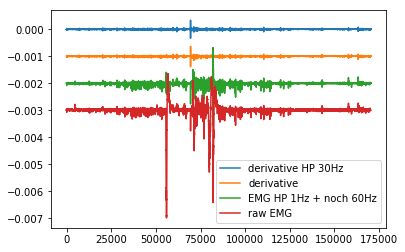

In [2]:
no_filt=raw.copy() # keep raw signal to compare whith filtered signal later

# EMG filtering
picks = mne.pick_types(raw.info, eeg=False , emg=True, ecg=False) # select channel to filter
raw.notch_filter(60, picks=picks, filter_length='auto', phase='zero') # notch filter 60Hz
raw.filter(1, None, picks=picks, filter_length='auto', phase='zero') # high pass filter 1Hz

# compute the EMG trigger channel (CHIN1-CHIN2) and inject it in trig_chaN1
trig_chaN1 = mne.pick_channels(raw.info['ch_names'], include=['CHIN1'])
trig_chaN2 = mne.pick_channels(raw.info['ch_names'], include=['CHIN2'])
trig_chan = raw._data[trig_chaN1[0], :] - raw._data[trig_chaN2[0], :]
raw._data[trig_chaN1[0], :]=trig_chan

# compute derivative EMG trigger channel and inject it in trig_chaN2
trig_chan_deriv = np.gradient(trig_chan[:])
raw._data[trig_chaN2[0], :]=trig_chan_deriv

# high pass filter on the derivative to remove slow slope
raw.filter(30, None, picks=trig_chaN2, filter_length='auto', phase='zero')

# plot raw EMG signal, filtered EMG, derivative and filtered derivative in the same graph
jitter = 1e-3 # set distance between curves
plt.plot(raw._data[trig_chaN2[0],:],label="derivative HP 30Hz")
plt.plot(trig_chan_deriv[:]-jitter,label="derivative")
plt.plot(raw._data[trig_chaN1[0],:]-2*jitter,label="EMG HP 1Hz + noch 60Hz"); 
plt.plot(no_filt._data[trig_chaN1[0], :] - no_filt._data[trig_chaN2[0], :] -3*jitter,label="raw EMG");
plt.legend()
plt.show()




### Define manually the best threshold (best signal/noise ratio) to be used for the automatic jerk detection (on filtered EMG or derivative): in this case we chose 8e-6 on filterd derivative

In [3]:
trig_chan=raw._data[trig_chaN2[0], :]# define the signal
thresh= 8e-6 # define the detection threshold

# additional features:
set_offset= 0 # set an offset if needed to incras precision (in secondes)
offset= int(round(raw.info['sfreq']*set_offset))
stim_length= int(round(raw.info['sfreq'] * (0.3))) # to avoid several triggers within 300ms

### Automatic detection of the jerk according to presets and plot the result

366 events found
Event IDs: [1]


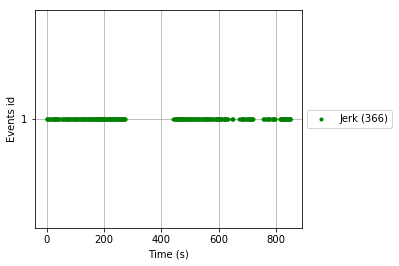

Setting up band-stop filter from 59 - 61 Hz
Filter length of 1321 samples (6.605 sec) selected
Setting up high-pass filter at 0.5 Hz
l_trans_bandwidth chosen to be 0.5 Hz
Filter length of 1321 samples (6.605 sec) selected
Applying average reference.


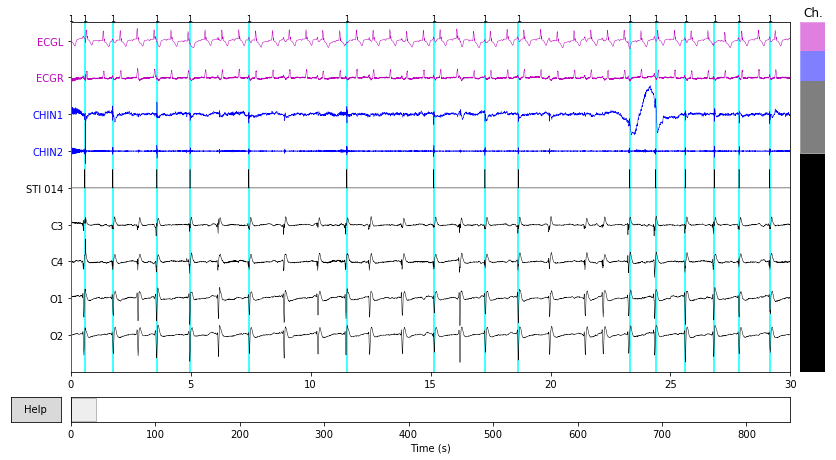

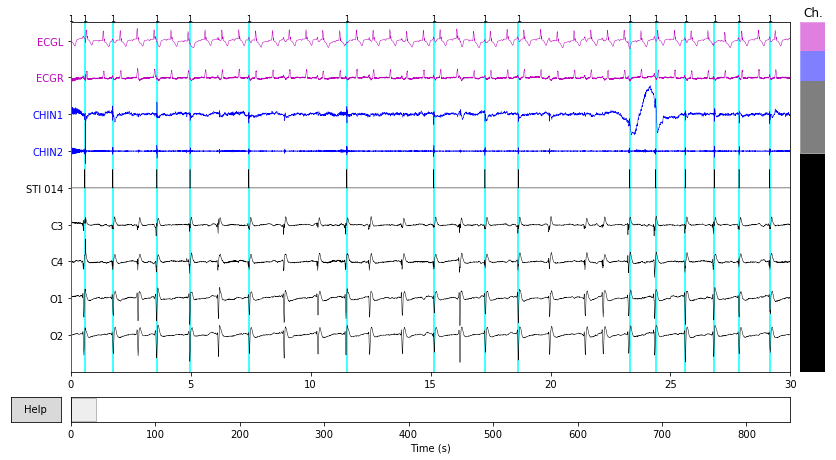

In [4]:
triggers = np.zeros_like(trig_chan)
trigs = []
i=0; j=trig_chan.shape[0];
while i < j:
    if np.abs(trig_chan[i]) > np.abs(thresh):
        trigs.append(i)
        i += stim_length
    else:
        i += 1
trigs = np.array(trigs)
triggers[trigs.astype(int)-offset] = 1

triggers[55100:88100] = 0   # manually remove triggers for some artefacted EEG

trig_ch = mne.pick_channels(raw.info['ch_names'], include=['STI 014'])
raw._data[trig_ch, :]=triggers # replace STI 014 by triggers

# find events from triggers STI 014 channel
events = mne.find_events(raw)
event_id = {'Jerk': 1}; color = {1: 'green'}
# plot detected events
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id)

# filter the EEG (high pass 0.5 Hz + 60Hz notch)
picks=mne.pick_types(raw.info, eeg=True , emg=False, ecg=True)
raw.notch_filter(60, picks=picks, filter_length='auto', phase='zero')
raw.filter(0.5, None , picks=picks) #

montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage) # set 10-20 montage for topoplot
raw.set_eeg_reference(ref_channels=None) # set avergage reference

""" plot EEG + EMG and detected events for visual inspection"""
raw.plot(show_options=True, events=events, block = True, n_channels=9,
scalings=dict(eeg=7e-5, ecg=8e-4,emg=5e-5),start=0,duration=30,
color=dict(eeg='k', ecg='m', emg='b'))


# Plot the back averaged EEG

366 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Channel locations not available. Disabling spatial colors.


<ipython-input-5-0ce83cb6868a>:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked.plot(spatial_colors=True, gfp=False, picks=picks, ylim = dict(eeg=[-50, 50],emg=[-80, 20]))


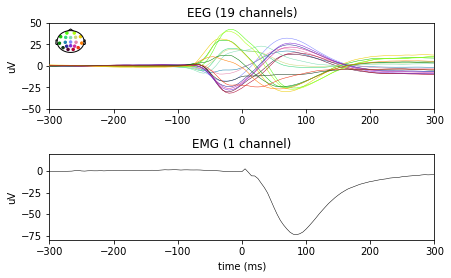

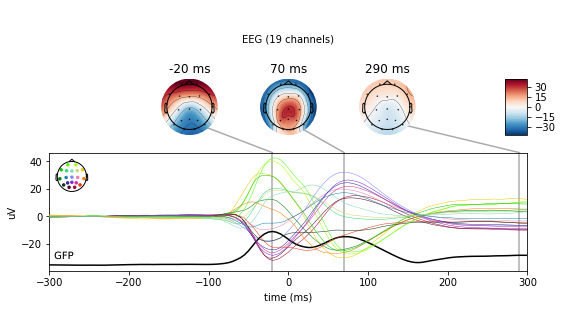

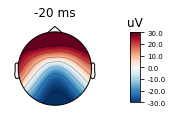

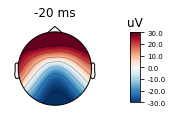

In [5]:
# epoch from -300 to + 300ms according to jerk with a baseline correction applied from -300 to -200ms
tmin, tmax = -0.300, 0.300
epochs = mne.Epochs(raw, events=events, event_id=event_id,tmin=tmin,tmax=tmax, baseline=(-0.3, -0.2))
picks=mne.pick_types(epochs.info, eeg=True, emg=True, ecg=True)
evoked=epochs['Jerk'].average(picks=picks) # avergaging


"""plot the results"""
# plot EEG with EMG
picks=np.hstack((  mne.pick_types(epochs.info, eeg=True), trig_chaN1  ))
evoked.plot(spatial_colors=True, gfp=False, picks=picks, ylim = dict(eeg=[-50, 50],emg=[-80, 20]))
# plot EEG with topoplots
ts_args = dict(gfp=True); topomap_args = dict(sensors=False)
evoked.plot_joint(title='', times='peaks',ts_args=ts_args)
# plot specific topoplot
evoked.plot_topomap(times=[-0.02],sensors=False,vmin=-30,vmax=30)